# Enhanced analysis for 10x Visium mouse olfactory bulb data

In this section, we show an example of enhanced analysis for 10x Visium mouse olfactory bulb (MOB) data using STForte. The enhanced analysis includes spatial domain identification and annotation/gene propagation in a padding scenario. The raw data is from the Gene Expression Omnibus (GEO) repository with accession No. [GSM4656181](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4656181). The `.h5ad` file can be downloaded from [STOmicsDB](https://db.cngb.org/stomics/datasets/STDS0000107) using the link https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000107/stomics/GSM4656181/GSM4656181_10x_Visium.h5ad.

In [1]:
import os
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as sc

from STForte import STGraph
from STForte import STForteModel
import STForte.helper as stfhelper
from STForte.helper import save_gdata, load_gdata

from STForte.helper import init_mclust_R, mclust_R
init_mclust_R()

from pathlib import Path
trial_name = "trial-MOB_10x_Visium"
trial_dir = Path().resolve() / trial_name
data_dir = Path().resolve() / ".." / "data" / "GSM4656181_10x_Visium.h5ad"
if not os.path.exists(trial_dir):
    os.makedirs(trial_dir)

Global seed set to 0
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



## Data loading & processing

First, we load and process the spatial resolved transcriptomics (SRT) data. The spatial graph is constructed based on distance neighbors. We used PCA to preprocess the gene experssion profiles. We masked the low-quality spots and employ a padding strategy to enable analysis at a fine-grained resolution, imputing the patterns for unobserved locations.

In [2]:
adata = sc.read_h5ad(data_dir)
adata

AnnData object with n_obs × n_vars = 918 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'
    layers: 'raw_count'

In [3]:
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    d=d,
    )
mask_idx = np.where(~sc.pp.filter_cells(adata, min_genes=200, inplace=False)[0])[0]  # mask low quality cells
stgraph.mask_nodes(mask_idx=mask_idx)
stgraph.pca()
stgraph.padding(reconstruct_knn=True, reconstruct_k=18)
gdata = stgraph.topyg()

d-based initialize:   0%|          | 0/918 [00:00<?, ?it/s]

PCA pre-compression for data, from 18110 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 3.31s.


brute-force knn initialize:   0%|          | 0/3535 [00:00<?, ?it/s]

## Fitting the STForte Model

We establish the model and fit it to obtain the latent encodings.

In [4]:
model = STForteModel(adata=adata, gdata=gdata,
                     output_dir=trial_dir / "pl_ckpts")
model.fit()

Global seed set to 42
/home/poncey/miniconda3/envs/stforte_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_ddf41a | 71.9 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K   

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.


Save the AnnData object, graph data, and model parameters for reproduction. Then, save the STForte output results. Model or data can be loaded for other analysis pipelines.

In [5]:
if not os.path.exists(trial_dir / "data"):
    os.makedirs(trial_dir / "data")
save_gdata(gdata, path=trial_dir / "data/gdata.pkl")
adata.write_h5ad(trial_dir / "data/trial.h5ad")
model.save_state_dict(trial_dir / "models", alias="STForteModel_mouse_olfa_10x")
# For analysis in original resolution
model.get_latent_original(adata)
if not os.path.exists(trial_dir / "outputs"):
    os.makedirs(trial_dir / "outputs")
adata.write(trial_dir / "outputs/stforte.h5ad")
# For analysis in padding resolution
adata_sp = model.get_result_anndata()
adata_sp.write_h5ad(trial_dir / "outputs/sp.h5ad")

## Spatial region identification and Visiualize STForte encodings 

STForte was designed so that different encodings address various spatial consistencies for homogeneous and heterogeneous SRT data. Here, We perform spatial region identification based on `mclust` in R and visualize the STForte encodings as follows.

In [6]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sc.set_figure_params(dpi=80 , fontsize=18)
plt.rcParams['font.sans-serif'] = [
    'Arial',
    'Helvetica',
    'sans-serif',]

In [7]:
# Spatial region identification through clustering
n_clusters = 6
adata = mclust_R(adata, n_clusters, "mclust_STForte_ATTR", used_obsm="STForte_ATTR")
adata = mclust_R(adata, n_clusters, "mclust_STForte_TOPO", used_obsm="STForte_TOPO")
adata = mclust_R(adata, n_clusters, "mclust_STForte_COMB", used_obsm="STForte_COMB")
# Create UMAP for different encodings
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    sc.pp.neighbors(adata, use_rep=f"{key}", key_added=f"STForte_{key}")
for key in ["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]:
    adata.obsm[f"{key}_umap"] = sc.tl.umap(adata, neighbors_key=f"STForte_{key}", copy=True).obsm['X_umap']

We select the COMB encoding, as the MOB region identification tends to be homogeneous.

<Axes: title={'center': 'mclust_STForte_COMB'}, xlabel='STForte_COMB_umap1', ylabel='STForte_COMB_umap2'>

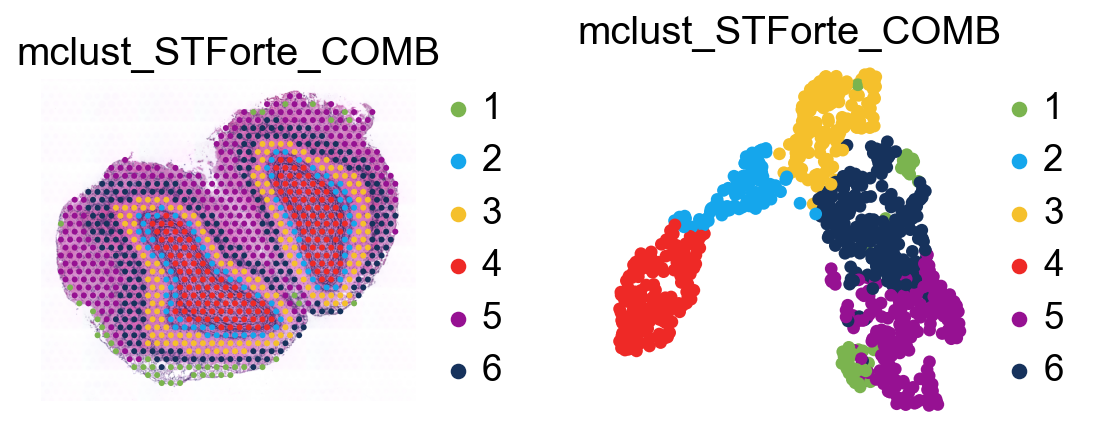

In [8]:
ncols, nrows = 2, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
sc.pl.spatial(
    adata,
    color=["mclust_STForte_COMB"],
    ax=axs[0],
    palette=stfhelper.pl.prism_1960s_palette,
    frameon=False,
    show=False,
)
sc.pl.embedding(
    adata,
    basis="STForte_COMB_umap",
    color="mclust_STForte_COMB",
    ax=axs[1],
    frameon=False,
    show=False,
)

We can also visualize other encodings generated by STForte.

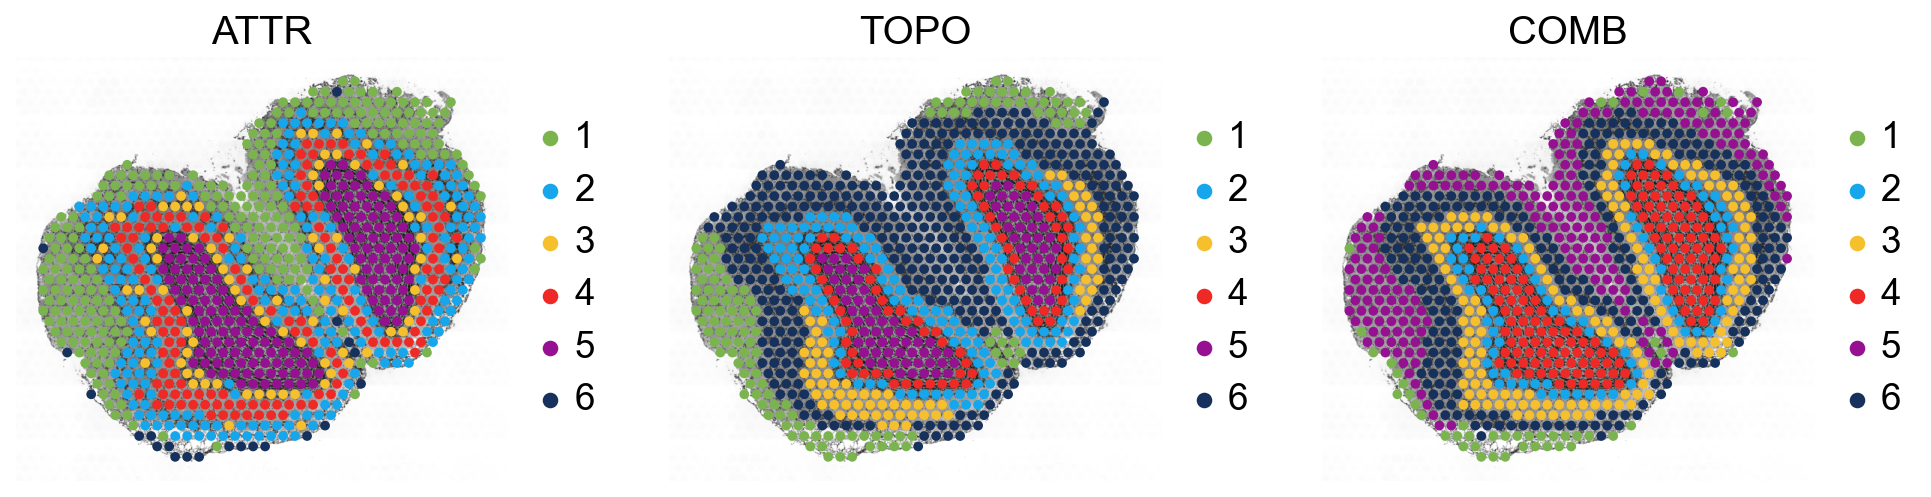

In [9]:
sc.pl.spatial(
    adata,
    color=["mclust_STForte_ATTR", "mclust_STForte_TOPO", "mclust_STForte_COMB"],
    img_key="hires",
    bw=True,
    size=1.25,
    frameon=False,
    title=["ATTR", "TOPO", "COMB"],
    palette=stfhelper.pl.prism_1960s_palette,
)

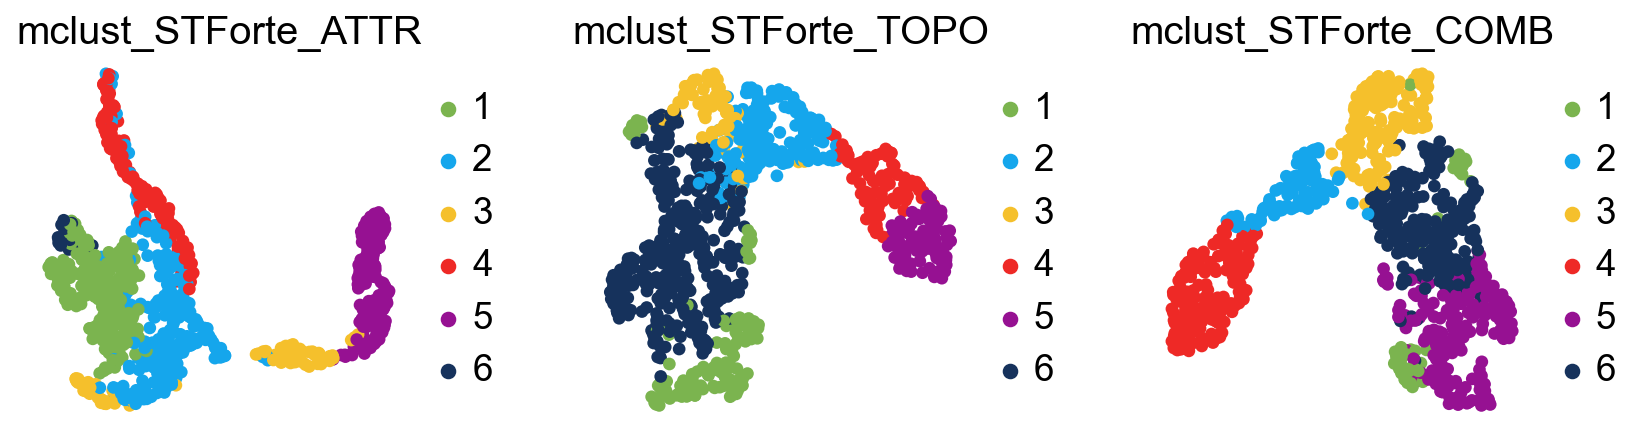

In [10]:
# Plot UMAP results
ncols, nrows = 3, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
for ii, key in enumerate(["STForte_ATTR", "STForte_TOPO", "STForte_COMB"]):
    sc.pl.embedding(
        adata,
        basis=f"{key}_umap",
        color=f"mclust_{key}",
        ax=axs[ii],
        frameon=False,
        show=False,
    )

## Enhanced Spatial Analysis of Unobserved Locations

STForte is applied for characterizing patterns of unobserved locations. We can access `adata_sp` generated by STForte to inspect these results. **Specifically, we use the TOPO encoding to propagate the annotated regions to the unobserved locations, considering that TOPO encoding provides more spatial consistency.**

In [11]:
# Propagate spatial regions
for key in ["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]:
    adata_sp.obs[f"mclust_STForte_COMB_pad_{key}"] = stfhelper.annotation_propagate(
        adata_sp, f"mclust_STForte_COMB", adata, latent_embed=key, copy=True
    )
# Calculate UMAPs
for key in ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    sc.pp.neighbors(adata_sp, use_rep=f"{key}", key_added=f"CONN_{key}")
for key in ["SP_ATTR_FP", "SP_TOPO", "SP_COMB"]:
    adata_sp.obsm[f"{key}_umap"] = sc.tl.umap(
        adata_sp, neighbors_key=f"CONN_{key}", copy=True
    ).obsm["X_umap"]

<Axes: title={'center': 'COMB pad by TOPO \n (UMAP)'}, xlabel='SP_TOPO_umap1', ylabel='SP_TOPO_umap2'>

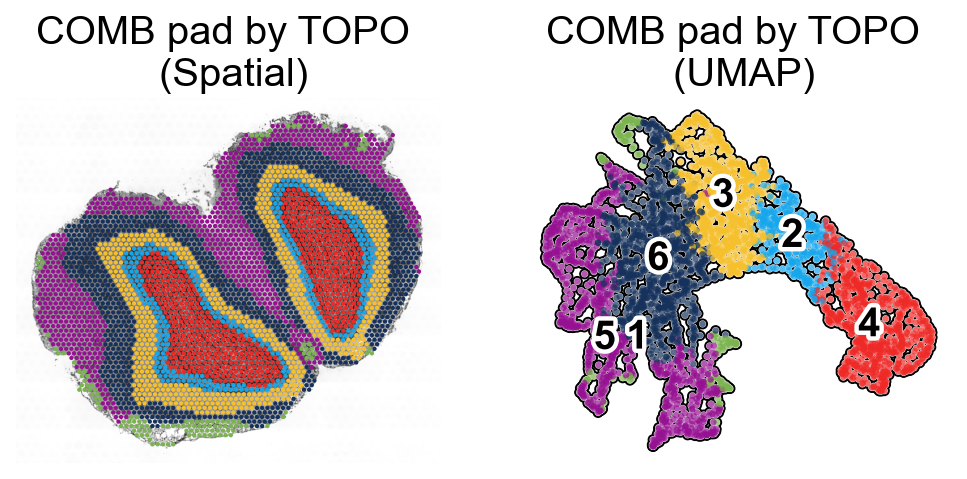

In [12]:
# Visiualize the padding results
ncols, nrows = 2, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
sc.pl.spatial(
    adata_sp,
    color=["mclust_STForte_COMB_pad_SP_TOPO"],
    size=0.625,
    bw=True,
    frameon=False,
    img=adata.uns["spatial"]["stomic"]["images"]["hires"],
    title="COMB pad by TOPO \n (Spatial)",
    spot_size=adata.uns["spatial"]["stomic"]["scalefactors"]["spot_diameter_fullres"],
    scale_factor=adata.uns["spatial"]["stomic"]["scalefactors"]["tissue_hires_scalef"],
    palette=stfhelper.pl.prism_1960s_palette,
    legend_fontoutline=4,
    legend_loc=None,
    show=False,
    ax=axs[0],
)
sc.pl.embedding(
    adata_sp,
    color=["mclust_STForte_COMB_pad_SP_TOPO"],
    basis="SP_TOPO_umap",
    title="COMB pad by TOPO \n (UMAP)",
    legend_loc="on data",
    legend_fontoutline=4,
    add_outline=True,
    palette=stfhelper.pl.prism_1960s_palette,
    show=False,
    frameon=False,
    ax=axs[1],
)

We can visualize the padding instances.

<Axes: title={'center': 'Instance pad by TOPO \n (UMAP)'}, xlabel='SP_TOPO_umap1', ylabel='SP_TOPO_umap2'>

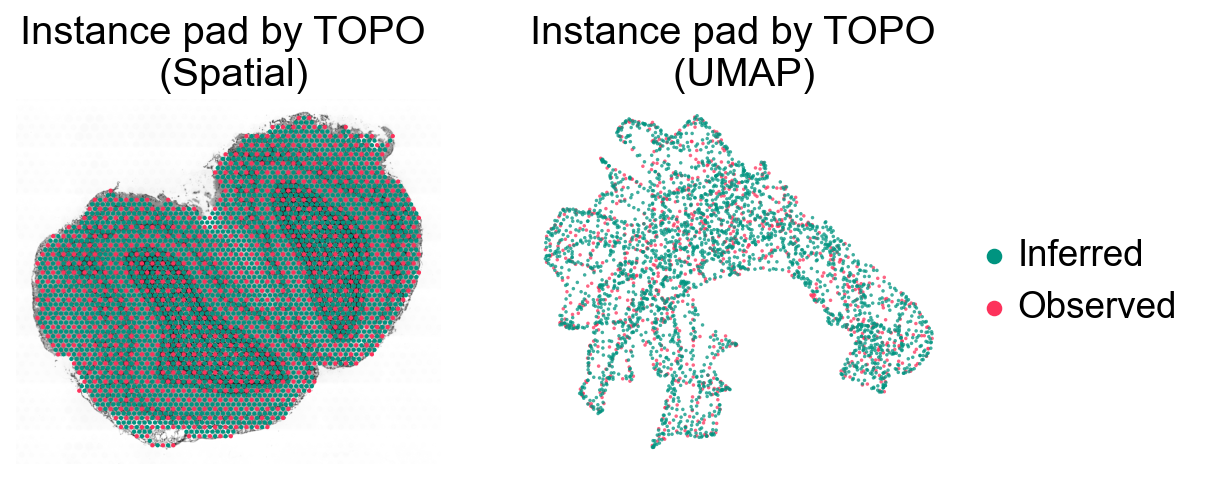

In [13]:
# Visiualize the padding instances
ncols, nrows = 2, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
sc.pl.spatial(
    adata_sp,
    color=["spot_instance"],
    size=0.625,
    bw=True,
    frameon=False,
    img=adata.uns["spatial"]["stomic"]["images"]["hires"],
    title="Instance pad by TOPO \n (Spatial)",
    spot_size=adata.uns["spatial"]["stomic"]["scalefactors"]["spot_diameter_fullres"],
    scale_factor=adata.uns["spatial"]["stomic"]["scalefactors"]["tissue_hires_scalef"],
    palette=stfhelper.pl.iwanthue_alphabet_hard[:2],
    legend_fontoutline=4,
    legend_loc=None,
    show=False,
    ax=axs[0],
)
sc.pl.embedding(
    adata_sp,
    color=["spot_instance"],
    basis="SP_TOPO_umap",
    alpha=.75,
    size=10.,
    title="Instance pad by TOPO \n (UMAP)",
    show=False,
    frameon=False,
    ax=axs[1],
)

We can also zoomin to inspect the results after padding.

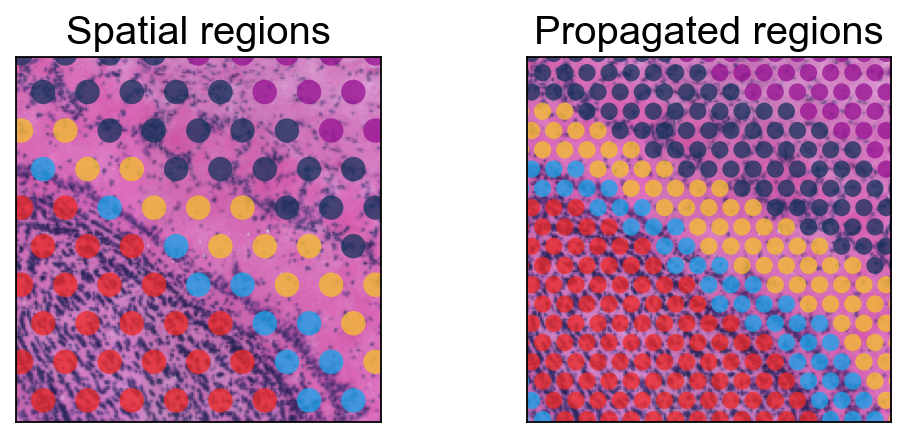

In [14]:
crop = [19200, 22200, 12000, 15000]
ncols, nrows = 2, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
sc.pl.spatial(adata, color=["mclust_STForte_COMB"],
            title="Spatial regions",
            crop_coord=crop,
            frameon=True, legend_loc=None,
            img_key="hires", size=0.85, alpha=0.75,
            show=False, ax=axs[0])
sc.pl.spatial(adata_sp, color=['mclust_STForte_COMB_pad_SP_TOPO'],
                    alpha=0.75, size=0.6,
                    crop_coord=crop,
                    img=adata.uns['spatial']['stomic']['images']['hires'], frameon=True, title="Propagated regions",
                    spot_size=adata.uns['spatial']['stomic']['scalefactors']['spot_diameter_fullres'], 
                    scale_factor=adata.uns['spatial']['stomic']['scalefactors']['tissue_hires_scalef'], 
                    legend_fontoutline=4, legend_loc=None,
                    show=False, ax=axs[1])
for ii in range(ncols):
    axs[ii].set_xlabel("")
    axs[ii].set_ylabel("")

Let us also inspect different padding encodings generated by STForte.

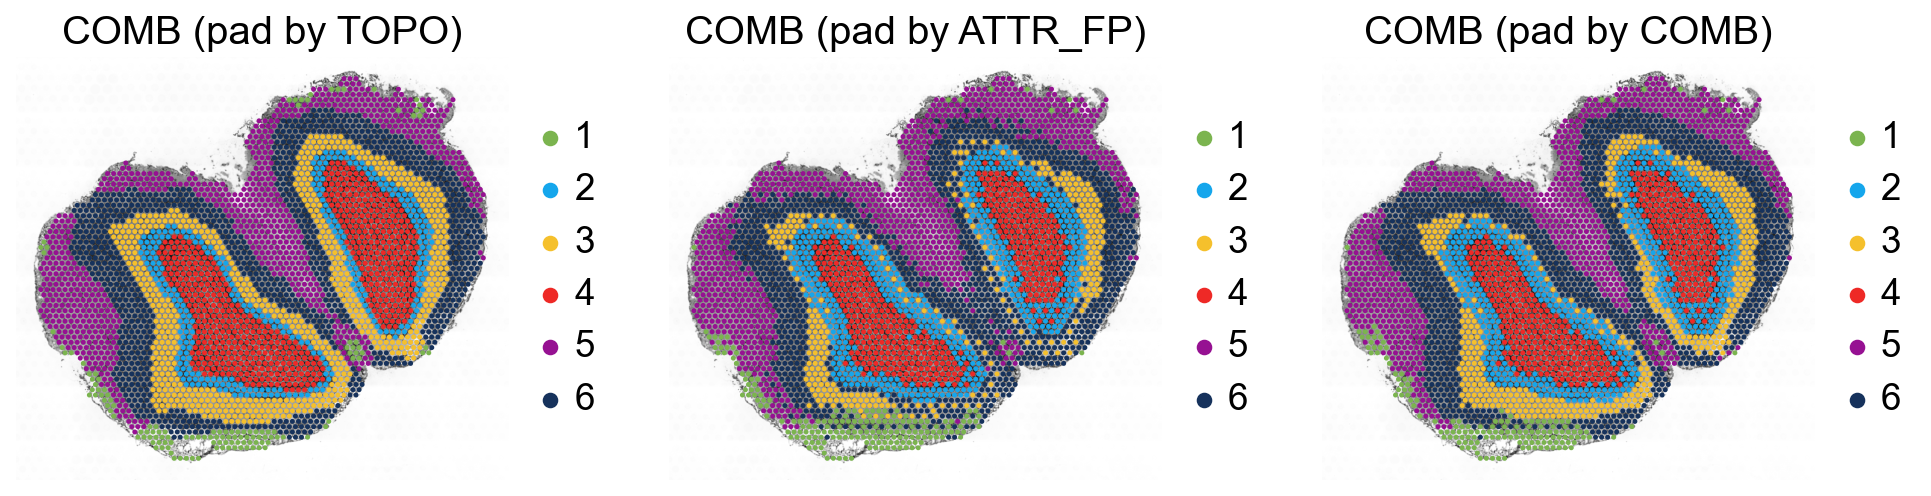

In [15]:
sc.pl.spatial(adata_sp, size=0.625, bw=True,
              color=[f'mclust_STForte_COMB_pad_SP_TOPO', f'mclust_STForte_COMB_pad_SP_ATTR_FP', f'mclust_STForte_COMB_pad_SP_COMB'], 
              title=[f'COMB (pad by TOPO)', f'COMB (pad by ATTR_FP)', f'COMB (pad by COMB)'],
              palette=stfhelper.pl.prism_1960s_palette,
              frameon=False,
              img=adata.uns['spatial']['stomic']['images']['hires'],
              spot_size=adata.uns['spatial']['stomic']['scalefactors']['spot_diameter_fullres'], 
              scale_factor=adata.uns['spatial']['stomic']['scalefactors']['tissue_hires_scalef'],)

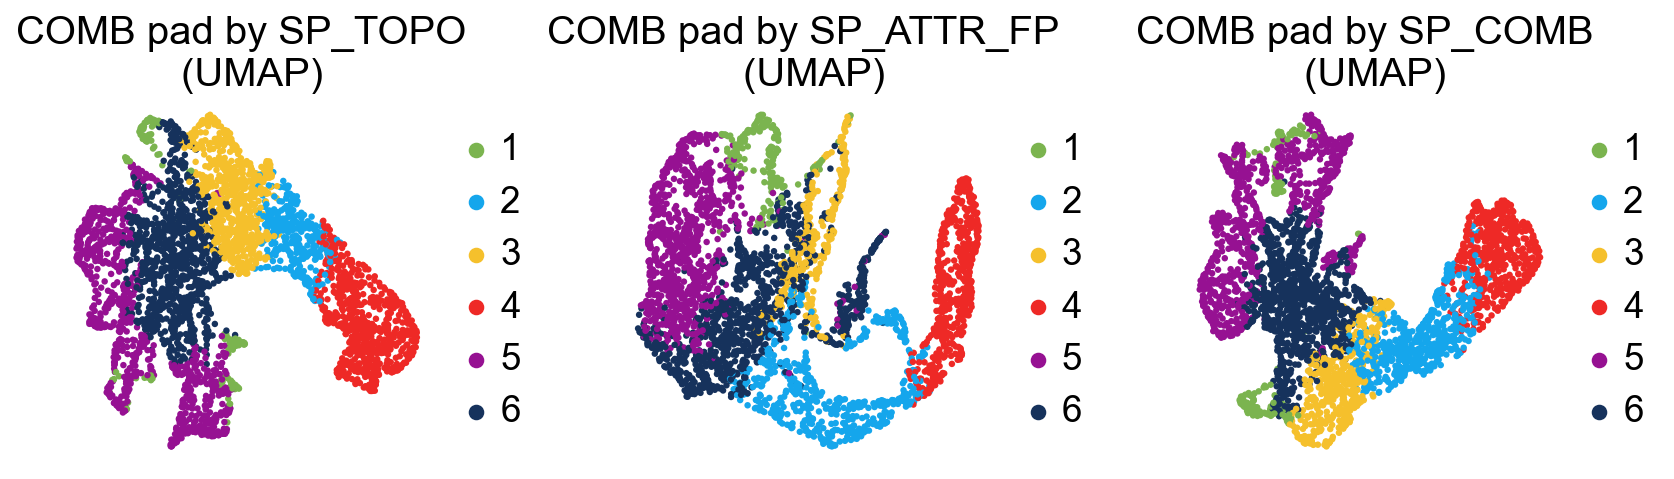

In [16]:
# Plot UMAP results
ncols, nrows = 3, 1
figsize, wspace = 3, 0.5
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
for ii, key in enumerate(["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]):
    sc.pl.embedding(
        adata_sp,
        basis=f"{key}_umap",
        color=f"mclust_STForte_COMB_pad_{key}",
        title=f"COMB pad by {key} \n (UMAP)",
        ax=axs[ii],
        frameon=False,
        show=False,
    )

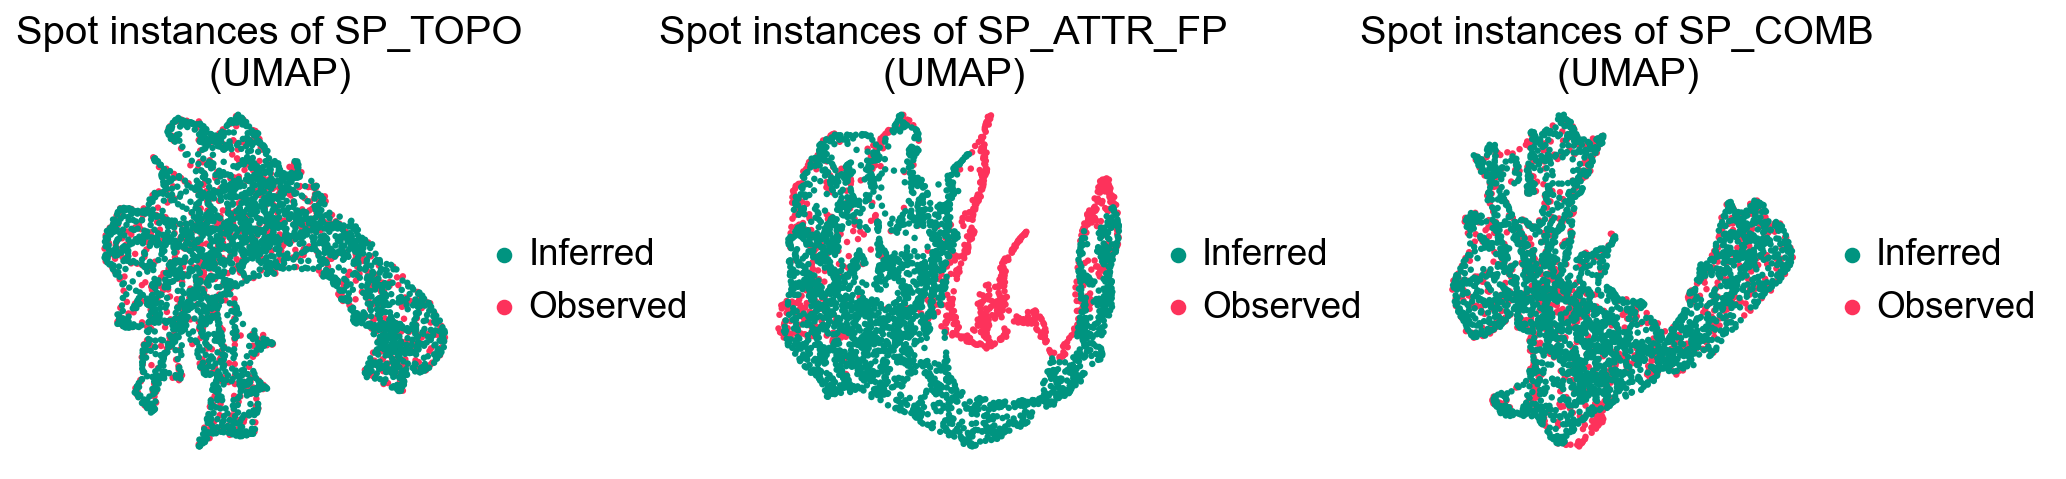

In [17]:
# Plot UMAP with instances
ncols, nrows = 3, 1
figsize, wspace = 3, 0.8
fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * figsize + figsize * wspace * (ncols - 1), nrows * figsize),
)
plt.subplots_adjust(wspace=wspace)
for ii, key in enumerate(["SP_TOPO", "SP_ATTR_FP", "SP_COMB"]):
    sc.pl.embedding(
        adata_sp,
        basis=f"{key}_umap",
        color=["spot_instance"],
        title=f"Spot instances of {key} \n (UMAP)",
        ax=axs[ii],
        frameon=False,
        show=False,
    )

## Spatial Imputation of Unobserved Expression Levels through STForte

STForte can perform spatial imputation to predict the expression levels of unobserved locations. The spatial imputation is performed after `sc.pp.normalize_total` and `sc.pp.log1p`.

Specifically, we choose some marker genes as examples: *Fabp7*, *Nrsn1*, *Bcl11b*, *Lhx2*, and *Meis2*.

First, we visualize these genes in the original SRT data.

In [18]:
adata.layers["raw_counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [19]:
gene_names = ['Fabp7', 'Nrsn1', 'Bc1', 'Lbhd2', 'Meis2']

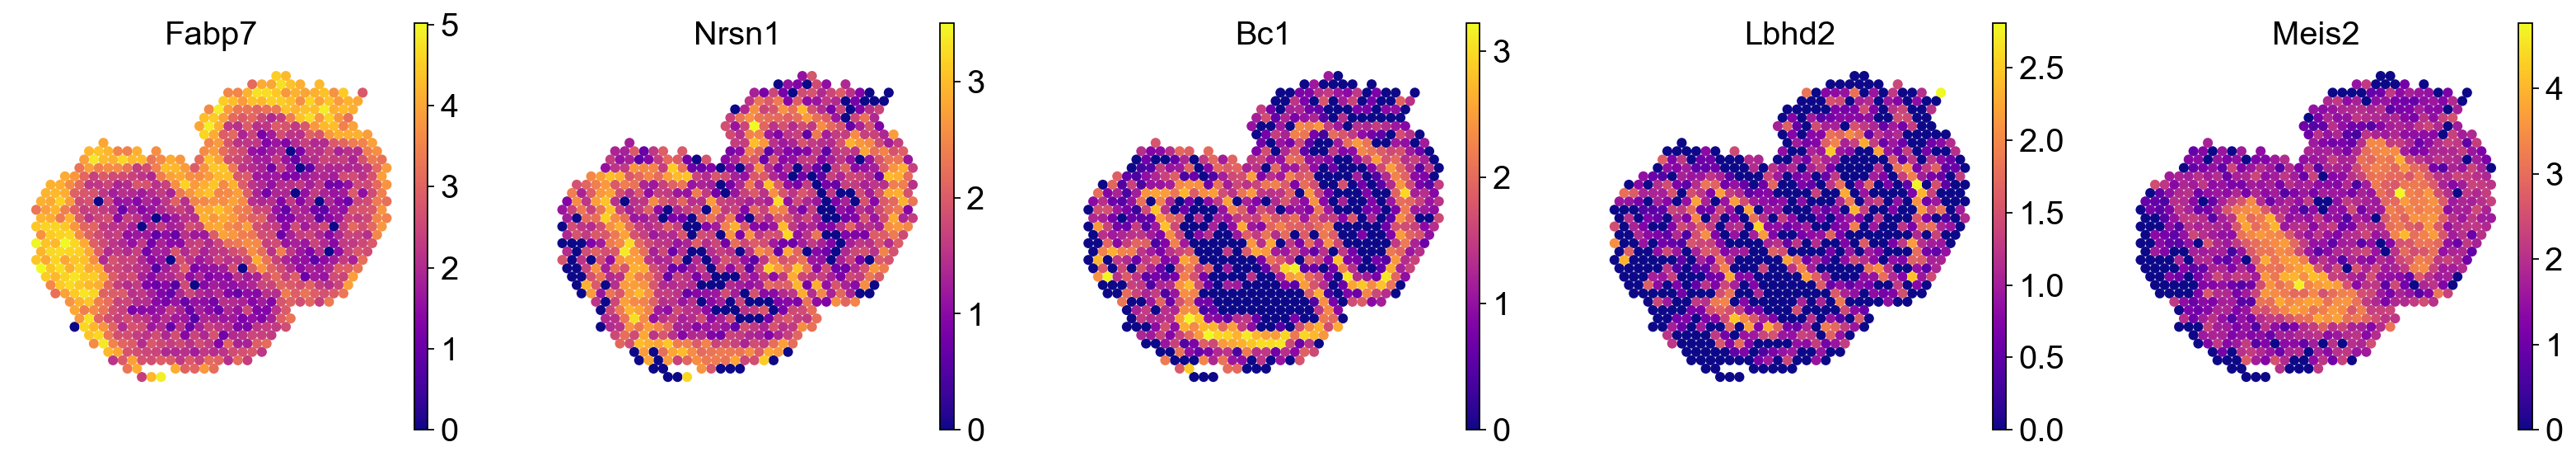

In [20]:
# Visiualize the entire section
with plt.rc_context():
    fig = sc.pl.spatial(adata, color=gene_names, ncols=5, alpha_img=0.0,
                         vmin=0,
                         frameon=False, 
                         cmap="plasma",
                         img_key="hires", size=1.6,
                         show=False,
                         return_fig=True,
                        )

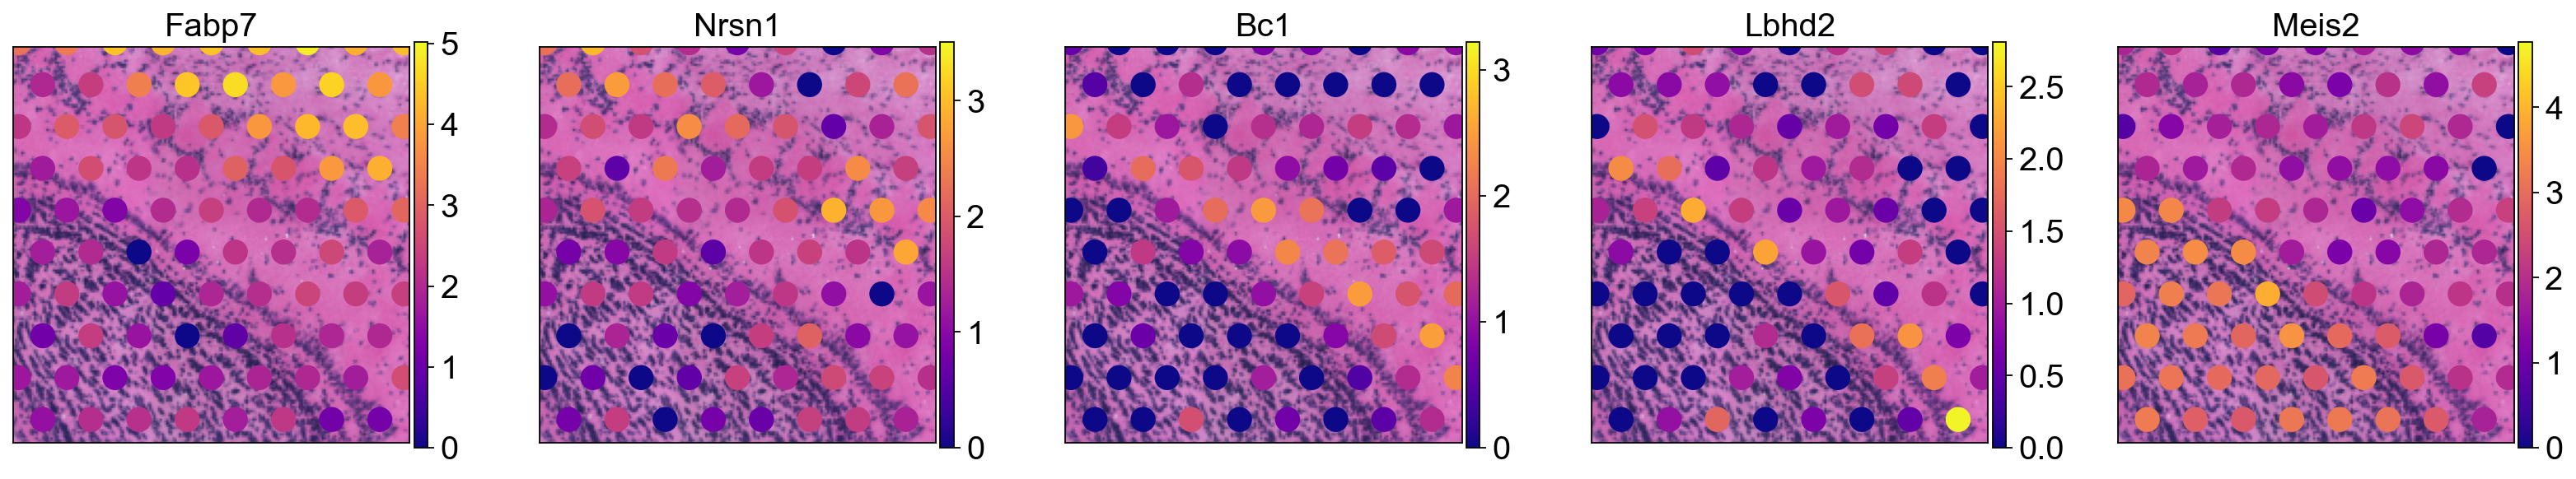

In [21]:
# Visiualize the zoomed-in section
with plt.rc_context():
    axes = sc.pl.spatial(adata, color=gene_names,
                         crop_coord=crop, ncols=5,
                         vmin=0,
                         cmap="plasma",
                         frameon=True, 
                         img_key="hires", size=0.8,
                         show=False,)
    for ax in axes:
        _ = ax.set_xlabel("")
        _ = ax.set_ylabel("")

Next, we perform the spatial imputation for the investigated genes and visualized the propagation results.

In [22]:
stfhelper.complete_unseen_expression(adata_sp, gene_names, adata)

Propagating genes...:   0%|          | 0/5 [00:00<?, ?it/s]

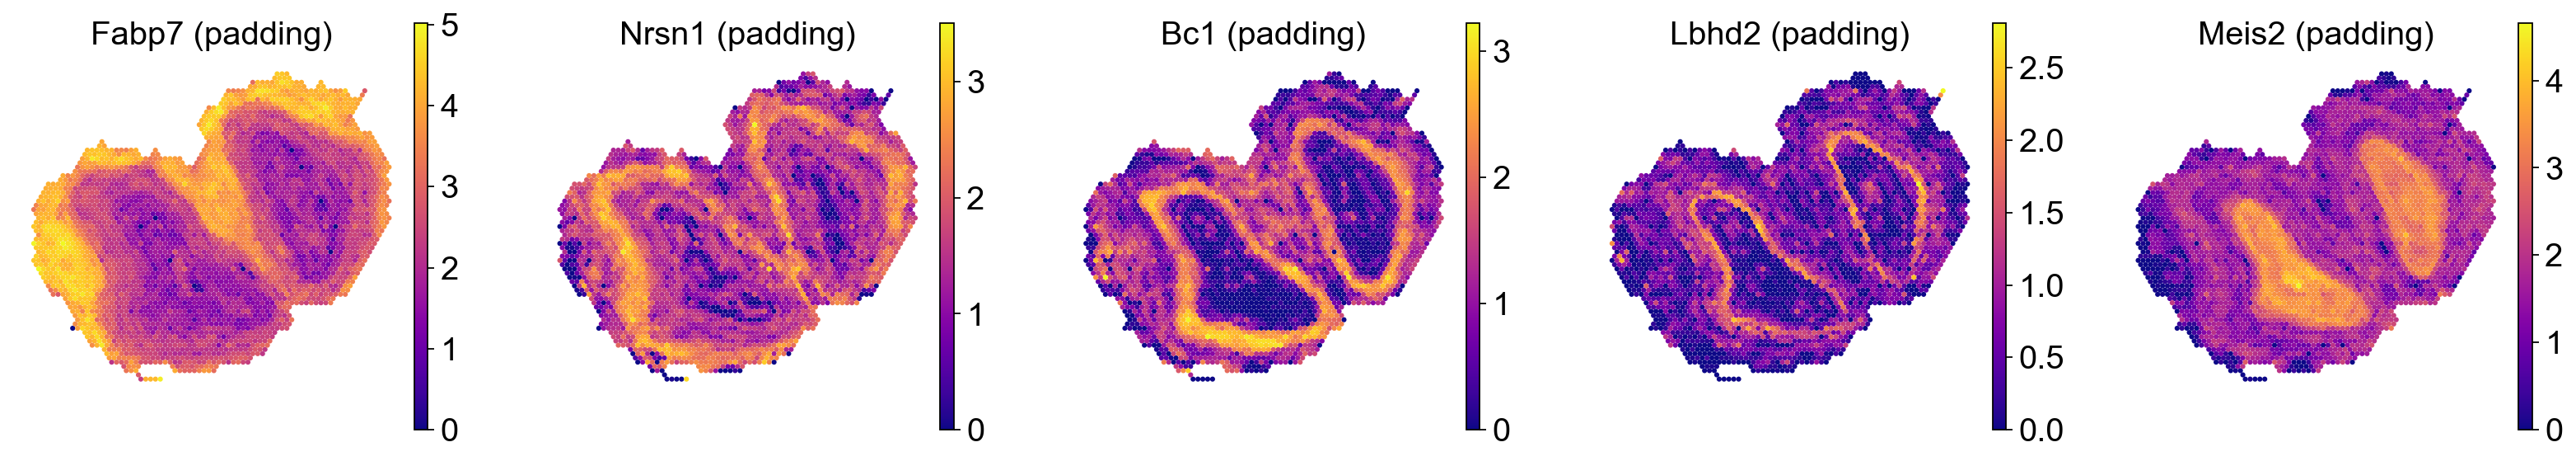

In [23]:
# Visiualize the entire section (padding)
with plt.rc_context():
    sc.pl.spatial(adata_sp, color=list(map(lambda s: s + "_with_padding", gene_names)), size=0.8,
                  vmin=0,
                  ncols=5, alpha_img=0.0,
                  title=[f"{gg} (padding)" for gg in gene_names],
                  cmap="plasma",
                  frameon=False,
                  img=adata.uns['spatial']['stomic']['images']['hires'],
                  spot_size=adata.uns['spatial']['stomic']['scalefactors']['spot_diameter_fullres'], 
                  scale_factor=adata.uns['spatial']['stomic']['scalefactors']['tissue_hires_scalef'],
                )

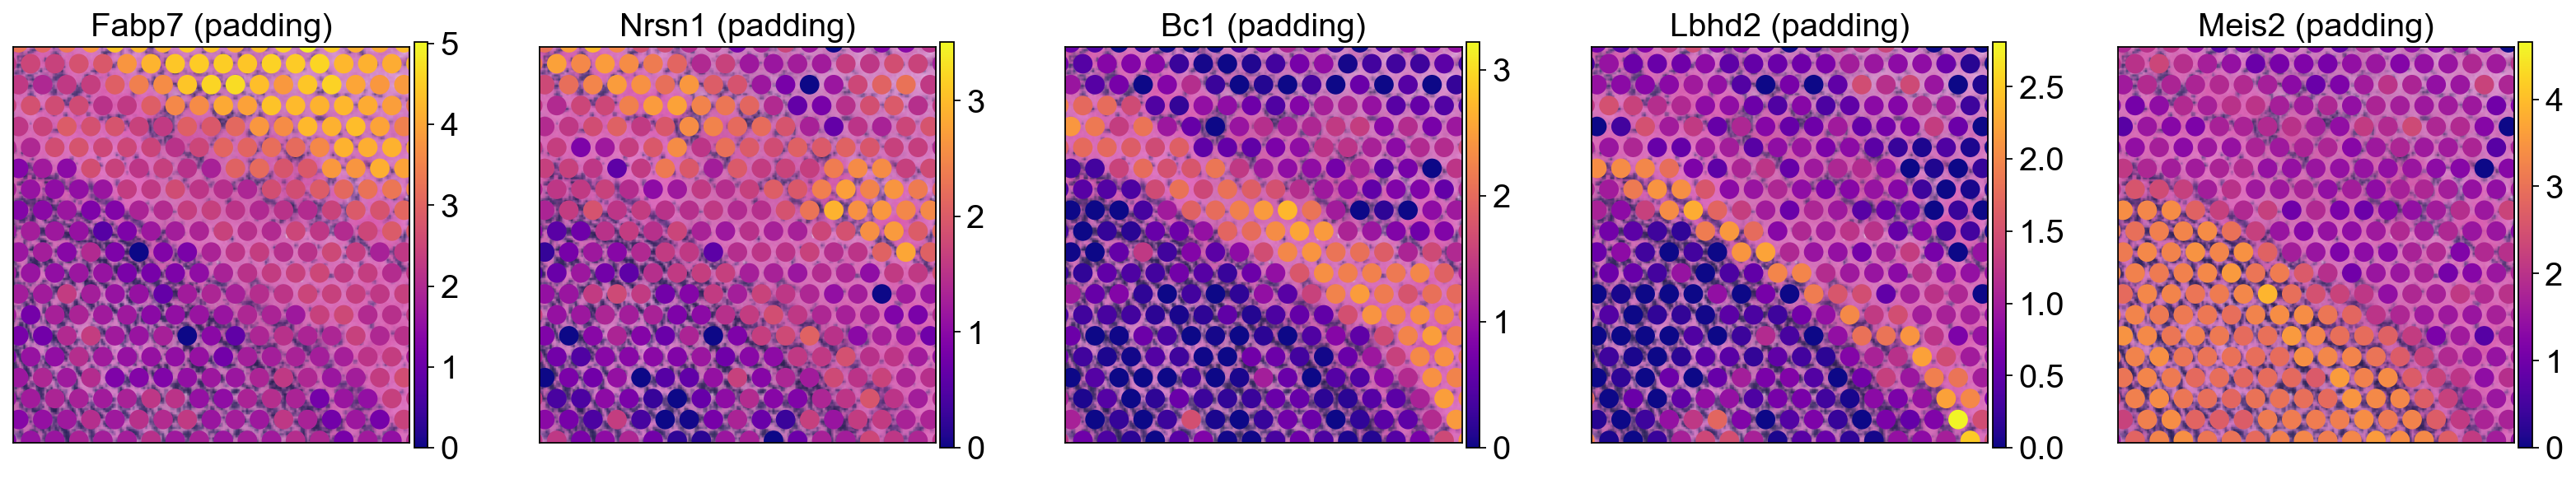

In [24]:
# Visiualize the zoomed-in section (padding)
with plt.rc_context():
    axes = sc.pl.spatial(adata_sp, color=list(map(lambda s: s + "_with_padding", gene_names)), size=0.625,
                         cmap="plasma",
                         ncols=5,
                         vmin=0,
                         title=[f"{gg} (padding)" for gg in gene_names],
                         frameon=True, 
                         crop_coord=crop,
                         img=adata.uns['spatial']['stomic']['images']['hires'],
                         spot_size=adata.uns['spatial']['stomic']['scalefactors']['spot_diameter_fullres'], 
                         scale_factor=adata.uns['spatial']['stomic']['scalefactors']['tissue_hires_scalef'],
                         show=False,
                         )
    for ax in axes:
        _ = ax.set_xlabel("")
        _ = ax.set_ylabel("")